In [1]:
!pip install -q datasets transformers torch accelerate scikit-learn seaborn matplotlib imbalanced-learn
print("✅ Cài đặt xong!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 40.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.nn import CrossEntropyLoss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc

print("✅ Import thành công!")
print(f"🔥 GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

E0000 00:00:1765278343.050444      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765278343.106163      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ Import thành công!
🔥 GPU: Tesla P100-PCIE-16GB


In [3]:
print("📦 Đang tải dataset...")
start_time = time.time()

data = load_dataset("pacovaldez/stackoverflow-questions", split="train")
sample = data.shuffle(seed=42).select(range(300000))

print(f"✅ Đã tải xong 300,000 mẫu trong {time.time()-start_time:.1f}s")

# PHÂN TÍCH PHÂN BỐ LABEL - QUAN TRỌNG!
print("\n" + "="*70)
print("📊 PHÂN TÍCH PHÂN BỐ DATASET")
print("="*70)
label_counts = pd.Series(sample["label"]).value_counts().sort_index()
label_pct = (label_counts / len(sample) * 100).round(2)

for label in range(4):
    count = label_counts[label]
    pct = label_pct[label]
    bar = "█" * int(pct / 2)
    print(f"Label {label}: {count:>6,} mẫu ({pct:>5.2f}%) {bar}")

print("="*70)

# Cảnh báo nếu imbalance quá cao
max_pct = label_pct.max()
min_pct = label_pct.min()
if max_pct / min_pct > 3:
    print("⚠️  CẢNH BÁO: Dataset có CLASS IMBALANCE cao!")
    print(f"   Tỷ lệ max/min: {max_pct/min_pct:.1f}x")
    print("   → Sẽ áp dụng Class Weights để cân bằng\n")

📦 Đang tải dataset...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.3M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/42.1M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.6M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/42.1M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/42.1M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/42.3M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

data/post_questions_train/post_questions(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

data/post_questions_validation/post_ques(…):   0%|          | 0.00/132M [00:00<?, ?B/s]

data/post_questions_validation/post_ques(…):   0%|          | 0.00/132M [00:00<?, ?B/s]

data/post_questions_validation/post_ques(…):   0%|          | 0.00/133M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.3M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/42.1M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.6M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.5M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/42.1M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.5M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

data/post_questions_test/post_questions_(…):   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1572294 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/785098 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1570866 [00:00<?, ? examples/s]

✅ Đã tải xong 300,000 mẫu trong 165.5s

📊 PHÂN TÍCH PHÂN BỐ DATASET
Label 0: 74,814 mẫu (24.94%) ████████████
Label 1: 74,786 mẫu (24.93%) ████████████
Label 2: 75,058 mẫu (25.02%) ████████████
Label 3: 75,342 mẫu (25.11%) ████████████


In [4]:
print("🔄 Đang tiền xử lý dữ liệu...")

texts = [title + " [SEP] " + body for title, body in zip(sample["title"], sample["body"])]
labels = sample["label"]

del data, sample
gc.collect()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=labels
)

print(f"✅ Chia dữ liệu:")
print(f"   Train: {len(train_texts):,} mẫu (270,000)")
print(f"   Val: {len(val_texts):,} mẫu (30,000)")

# Tính class weights
train_label_counts = np.bincount(train_labels)
class_weights = len(train_labels) / (len(train_label_counts) * train_label_counts)
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"\n💪 Class Weights:")
for i, w in enumerate(class_weights):
    print(f"   Label {i}: {w:.3f}")

🔄 Đang tiền xử lý dữ liệu...
✅ Chia dữ liệu:
   Train: 270,000 mẫu (270,000)
   Val: 30,000 mẫu (30,000)

💪 Class Weights:
   Label 0: 1.002
   Label 1: 1.003
   Label 2: 0.999
   Label 3: 0.995


In [5]:
print("\n🔤 Đang tokenize 300K mẫu...")

model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels})

del train_texts, val_texts, texts, labels
gc.collect()

def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        truncation=True, 
        max_length=384,
        padding=False
    )

train_ds = train_ds.map(
    tokenize_function, 
    batched=True, 
    batch_size=1000,
    remove_columns=["text"],
    desc="Tokenizing 270K train samples"
)
val_ds = val_ds.map(
    tokenize_function, 
    batched=True, 
    batch_size=1000,
    remove_columns=["text"],
    desc="Tokenizing 30K val samples"
)

train_ds.set_format("torch")
val_ds.set_format("torch")

print("✅ Tokenize xong 300K mẫu!")


🔤 Đang tokenize 300K mẫu...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizing 270K train samples:   0%|          | 0/270000 [00:00<?, ? examples/s]

Tokenizing 30K val samples:   0%|          | 0/30000 [00:00<?, ? examples/s]

✅ Tokenize xong 300K mẫu!


In [8]:
print("\n🤖 Đang khởi tạo model...")

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, 4), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ TỐI ƯU CHO 300K - 7 EPOCHS
training_args = TrainingArguments(
    output_dir='./so-model-300k',
    num_train_epochs=7,  # 
    per_device_train_batch_size=24,
    per_device_eval_batch_size=48,
    gradient_accumulation_steps=3,  # Effective = 72
    warmup_ratio=0.12,  # ✅ Giảm warmup xuống 12% (300k data nhiều hơn)
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_steps=200,  # ✅ Log ít hơn (mỗi epoch có nhiều steps)
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    fp16=True,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    seed=42,
    max_grad_norm=1.0,
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    
    metrics = {"accuracy": acc, "f1": f1}
    
    for label in range(4):
        mask = labels == label
        if mask.sum() > 0:
            metrics[f'acc_label_{label}'] = (preds[mask] == label).sum() / mask.sum()
    
    return metrics

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("✅ Weighted Trainer đã sẵn sàng!")



🤖 Đang khởi tạo model...


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Weighted Trainer đã sẵn sàng!


In [15]:
print("\n" + "="*70)
print("🚀7 bước gọt mít xin được phép bắt đầu =)))" )

training_start = time.time()
train_result = trainer.train()
training_time = time.time() - training_start

print("\n" + "="*70)
print(f"Hoàn tất gọt mít!")
print(f"⏱️  Tổng thời gian: {training_time/60:.1f} phút ({training_time/3600:.2f} giờ)")
epochs_trained = len([log for log in trainer.state.log_history if 'eval_loss' in log])
print(f"⏱️  Đã train: {epochs_trained} epochs")
print(f"⏱️  Thời gian/epoch: {training_time/epochs_trained/60:.1f} phút")
print("="*70)


🚀7 bước gọt mít xin được phép bắt đầu =)))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [10]:
print("\n📊 Đang đánh giá model trên 30K validation samples...")

eval_result = trainer.evaluate()

print("\n" + "="*70)
print("📈 KẾT QUẢ CUỐI CÙNG - 300K MẪU:")
print("="*70)
print(f"✨ Overall Accuracy: {eval_result['eval_accuracy']*100:.2f}%")
print(f"✨ Macro F1 Score: {eval_result['eval_f1']:.4f}")
print(f"\n📊 Accuracy từng class:")

class_accs = []
for i in range(4):
    key = f'eval_acc_label_{i}'
    if key in eval_result:
        acc = eval_result[key] * 100
        class_accs.append(acc)
        status = "✅" if acc >= 65 else "⚠️" if acc >= 55 else "❌"
        print(f"   {status} Label {i}: {acc:.2f}%")

print(f"\n📊 Phân tích:")
print(f"   - Accuracy cao nhất: {max(class_accs):.2f}%")
print(f"   - Accuracy thấp nhất: {min(class_accs):.2f}%")
print(f"   - Chênh lệch: {max(class_accs) - min(class_accs):.2f}%")
print("="*70)


📊 Đang đánh giá model trên 30K validation samples...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



📈 KẾT QUẢ CUỐI CÙNG - 300K MẪU:
✨ Overall Accuracy: 41.21%
✨ Macro F1 Score: 0.3994

📊 Accuracy từng class:
   ⚠️ Label 0: 64.38%
   ❌ Label 1: 23.14%
   ❌ Label 2: 29.18%
   ❌ Label 3: 48.13%

📊 Phân tích:
   - Accuracy cao nhất: 64.38%
   - Accuracy thấp nhất: 23.14%
   - Chênh lệch: 41.23%


In [11]:
print("\n📋 Đang tạo Classification Report...")

predictions = trainer.predict(val_ds)
preds = predictions.predictions.argmax(axis=1)

print("\n" + "="*70)
print("📋 CLASSIFICATION REPORT CHI TIẾT:")
print("="*70)
print(classification_report(
    val_labels, preds, 
    target_names=[f'Label {i}' for i in range(4)],
    digits=4
))


📋 Đang tạo Classification Report...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



📋 CLASSIFICATION REPORT CHI TIẾT:
              precision    recall  f1-score   support

     Label 0     0.4302    0.6438    0.5157      7481
     Label 1     0.3194    0.2314    0.2684      7479
     Label 2     0.3463    0.2918    0.3167      7506
     Label 3     0.5135    0.4813    0.4968      7534

    accuracy                         0.4121     30000
   macro avg     0.4023    0.4121    0.3994     30000
weighted avg     0.4025    0.4121    0.3995     30000



📊 Đang vẽ Confusion Matrix...


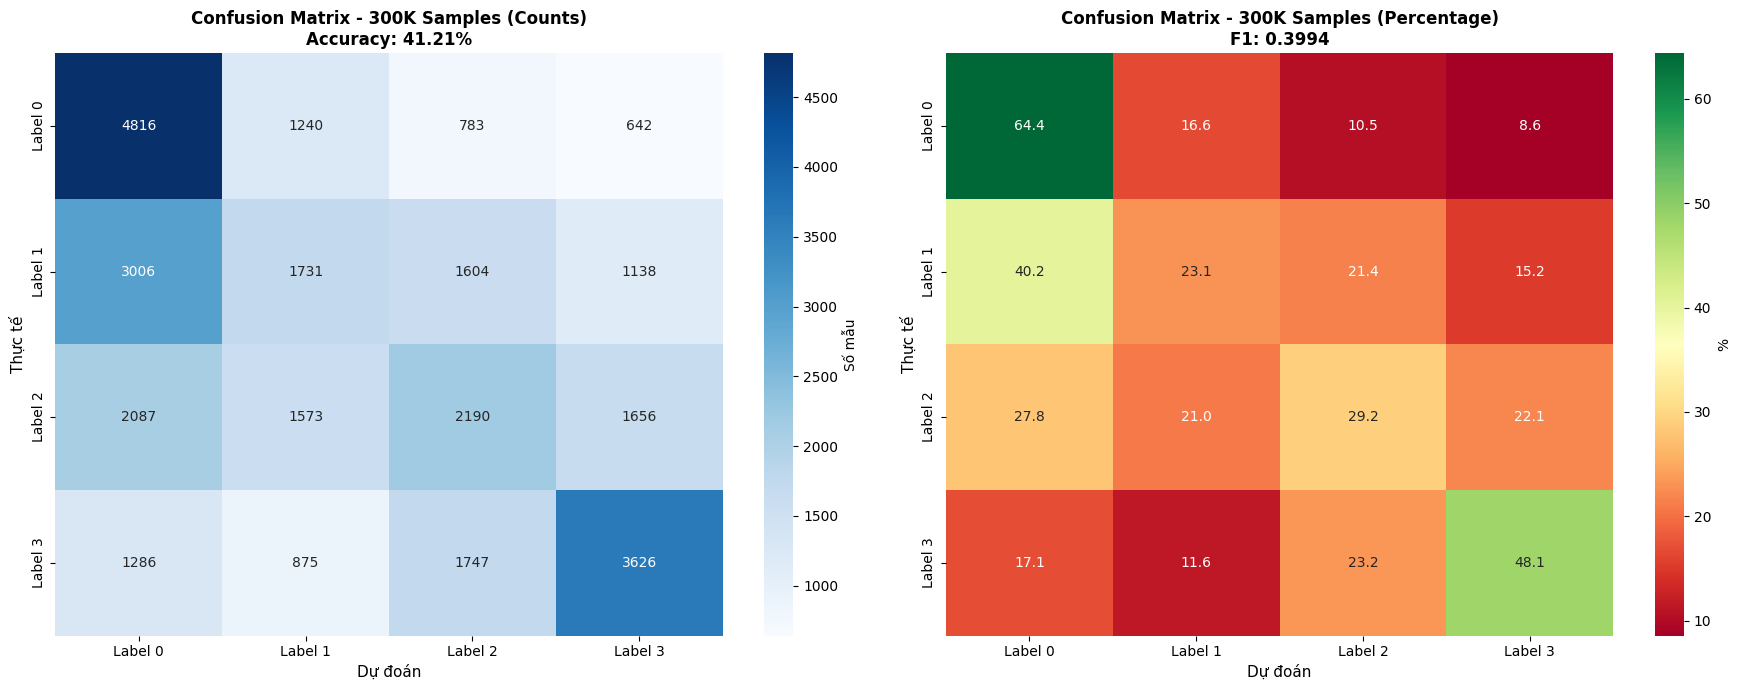

✅ Đã lưu: confusion_matrix_300k.png


In [12]:
print("📊 Đang vẽ Confusion Matrix...")

cm = confusion_matrix(val_labels, preds)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# CM với số lượng
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[f'Label {i}' for i in range(4)],
            yticklabels=[f'Label {i}' for i in range(4)],
            cbar_kws={'label': 'Số mẫu'})
axes[0].set_title(f"Confusion Matrix - 300K Samples (Counts)\nAccuracy: {eval_result['eval_accuracy']*100:.2f}%", 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel("Dự đoán", fontsize=11)
axes[0].set_ylabel("Thực tế", fontsize=11)

# CM với %
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1],
            xticklabels=[f'Label {i}' for i in range(4)],
            yticklabels=[f'Label {i}' for i in range(4)],
            cbar_kws={'label': '%'})
axes[1].set_title(f"Confusion Matrix - 300K Samples (Percentage)\nF1: {eval_result['eval_f1']:.4f}", 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel("Dự đoán", fontsize=11)
axes[1].set_ylabel("Thực tế", fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrix_300k.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Đã lưu: confusion_matrix_300k.png")



📈 Đang vẽ Training History...


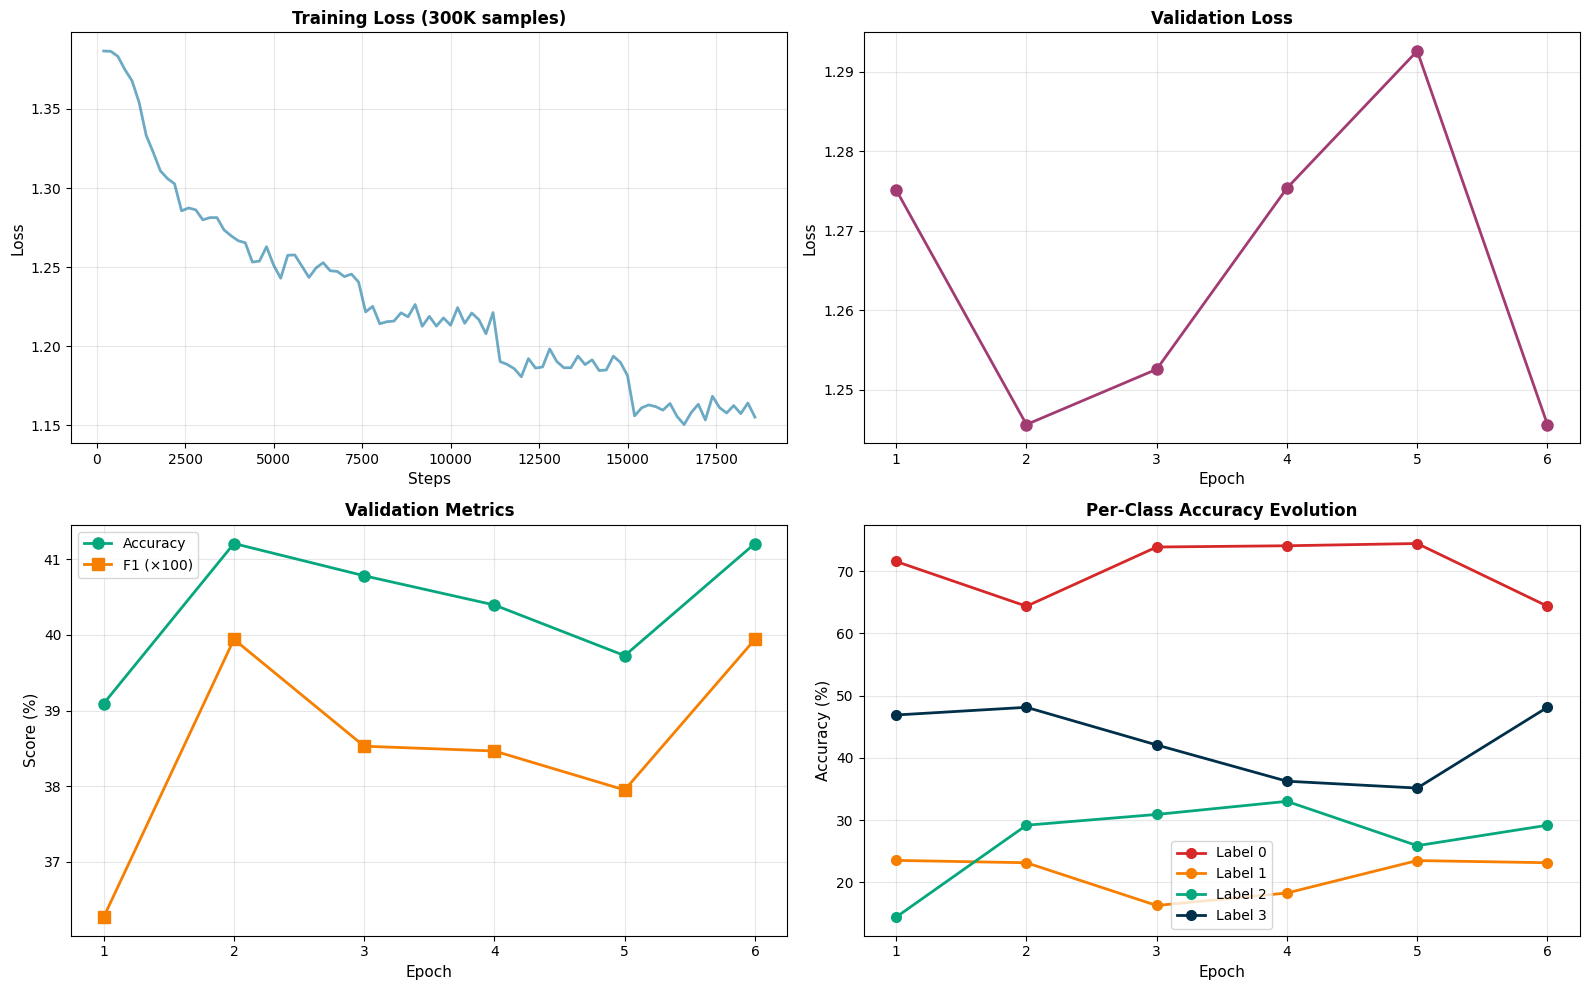

✅ Đã lưu: training_history_300k.png


In [13]:
print("\n📈 Đang vẽ Training History...")

log_history = trainer.state.log_history
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training Loss
if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    axes[0, 0].plot(steps, losses, linewidth=2, color='#2E86AB', alpha=0.7)
    axes[0, 0].set_xlabel('Steps', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('Training Loss (300K samples)', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
if eval_logs:
    epochs = list(range(1, len(eval_logs) + 1))
    val_losses = [log['eval_loss'] for log in eval_logs]
    axes[0, 1].plot(epochs, val_losses, marker='o', linewidth=2, markersize=8, color='#A23B72')
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Loss', fontsize=11)
    axes[0, 1].set_title('Validation Loss', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

# Accuracy & F1
if eval_logs:
    epochs = list(range(1, len(eval_logs) + 1))
    accs = [log['eval_accuracy'] * 100 for log in eval_logs]
    f1s = [log['eval_f1'] * 100 for log in eval_logs]
    
    axes[1, 0].plot(epochs, accs, marker='o', linewidth=2, markersize=8, label='Accuracy', color='#06A77D')
    axes[1, 0].plot(epochs, f1s, marker='s', linewidth=2, markersize=8, label='F1 (×100)', color='#F77F00')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Score (%)', fontsize=11)
    axes[1, 0].set_title('Validation Metrics', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

# Per-class Accuracy
if eval_logs:
    epochs = list(range(1, len(eval_logs) + 1))
    colors = ['#D62828', '#F77F00', '#06A77D', '#003049']
    
    for i in range(4):
        key = f'eval_acc_label_{i}'
        if key in eval_logs[0]:
            accs = [log[key] * 100 for log in eval_logs]
            axes[1, 1].plot(epochs, accs, marker='o', linewidth=2, markersize=7, 
                          label=f'Label {i}', color=colors[i])
    
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Per-Class Accuracy Evolution', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_300k.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Đã lưu: training_history_300k.png")

In [14]:
print("\n💾 Đang lưu model...")

acc_str = f"{eval_result['eval_accuracy']*100:.1f}"
f1_str = f"{eval_result['eval_f1']:.3f}".replace('.', '_')
model_save_path = f"so-model-300k-acc{acc_str}-f1{f1_str}"

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

import json
training_info = {
    "model_name": model_name,
    "dataset_size": 300000,
    "train_samples": 270000,
    "val_samples": 30000,
    "num_epochs_planned": 7,
    "num_epochs_trained": epochs_trained,
    "batch_size": 24,
    "gradient_accumulation_steps": 3,
    "effective_batch_size": 72,
    "learning_rate": 2e-5,
    "max_length": 384,
    "accuracy": float(eval_result['eval_accuracy']),
    "f1_score": float(eval_result['eval_f1']),
    "training_time_hours": training_time / 3600,
    "per_class_accuracy": {
        f"label_{i}": float(eval_result[f'eval_acc_label_{i}']) 
        for i in range(4) if f'eval_acc_label_{i}' in eval_result
    },
    "optimizations": [
        "300K samples (50% more than 200K)",
        "7 epochs (optimal for larger dataset)",
        "Class Weights for imbalanced data",
        "Max length 384 tokens",
        "Learning rate 2e-5",
        "Early stopping patience=3",
        "Gradient clipping max_norm=1.0",
        "Warmup ratio 12%"
    ]
}

with open(f"{model_save_path}/training_info.json", "w", encoding='utf-8') as f:
    json.dump(training_info, f, indent=2, ensure_ascii=False)

print(f"✅ Đã lưu model: {model_save_path}")



💾 Đang lưu model...
✅ Đã lưu model: so-model-300k-acc41.2-f10_399
